In [3]:
%matplotlib inline

import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import fileinput

#Fit the code to the screen
from IPython.core.display import HTML
HTML("<style>.container { width:100% !important; }</style>")

In [4]:
#Reading the movies data
my_path = !pwd
movies_filename = "/ml-20/movies.csv"
dfmovies = pd.read_csv(my_path[0]+movies_filename, index_col=None, sep=',')

In [3]:
#Extract the year from the title
dfmovies["year"] = dfmovies['title'].apply(lambda x: x[x.rfind("(")+1:x.rfind(")")])
dfmovies["name"] = dfmovies['title'].apply(lambda x: x[:x.rfind("(")-1])
del dfmovies['title']
#Get the columns to the original order
cols = dfmovies.columns.tolist()
cols = cols[:1] + cols[-1:] + cols[-2:-1] + cols[1:2]
dfmovies = dfmovies[cols]

In [4]:
#Reading the ratings data
ratings_filename = "/ml-20/ratings.csv"
dfratings = pd.read_csv(my_path[0]+ratings_filename, index_col=None, sep=',')my_path[0]+ratings_filename, index_col=None, sep=',')

In [ ]:
#Check how many movies have enough ratings
ratings_num = []
movie_ids = (dfratings["movieId"]).unique()
for movie in movie_ids:
    ratings_num.append(dfratings[dfratings["movieId"] == movie].shape[0])

[175]


In [ ]:
#Create df of movies ids and ratings count
ratings_cnt = pd.DataFrame([movie_ids, ratings_num])
ratings_cnt = ratings_cnt.transpose()
ratings_cnt.columns = ["movieId", "ratingsCount"]

In [ ]:
with open(my_path[0]+'/explore/ratings_cnt.pik', 'wb') as handle:
    pickle.dump(ratings_cnt, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [74]:
#Create df of user ids and ratings count
user_ratings_filename = "/ml-20/usersCnt.csv"
user_ratings_cnt = pd.read_csv(my_path[0]+user_ratings_filename, index_col=None, sep=',')

In [78]:
user_ratings_cnt["ratingsCount"].describe()
with open(my_path[0]+'/explore/user_ratings_cnt.pik', 'wb') as handle:
    pickle.dump(user_ratings_cnt, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
(n, bins, patches) = plt.hist(ratings_cnt["ratingsCount"], bins=np.arange(1,1000, 100))
plt.show()

In [5]:
# Get movie and user ratings
ratings_cnt = pickle.load(open(my_path[0]+'/explore/ratings_cnt.pik', 'rb'))
user_ratings_cnt = pickle.load(open(my_path[0]+'/explore/user_ratings_cnt.pik', 'rb'))
#ratings_cnt.describe()
user_ratings_cnt["ratingsCount"].describe()

count    138492.000000
mean        144.411879
std         230.267269
min          20.000000
25%          35.000000
50%          68.000000
75%         155.000000
max        9254.000000
Name: ratingsCount, dtype: float64

In [8]:
ratings_cnt["ratingsCount"].describe()

count    26744.000000
mean       747.841123
std       3085.818268
min          1.000000
25%          3.000000
50%         18.000000
75%        205.000000
max      67310.000000
Name: ratingsCount, dtype: float64

[4485    0    0 ...,    0    0    1]
[   20.            20.06667533    20.13335066 ...,  9253.86664934
  9253.93332467  9254.        ]
3.23845420674
137
2594
(26744,)


([<matplotlib.axis.XTick at 0x7fbb4ef0ced0>,
 <a list of 5 Text xticklabel objects>)

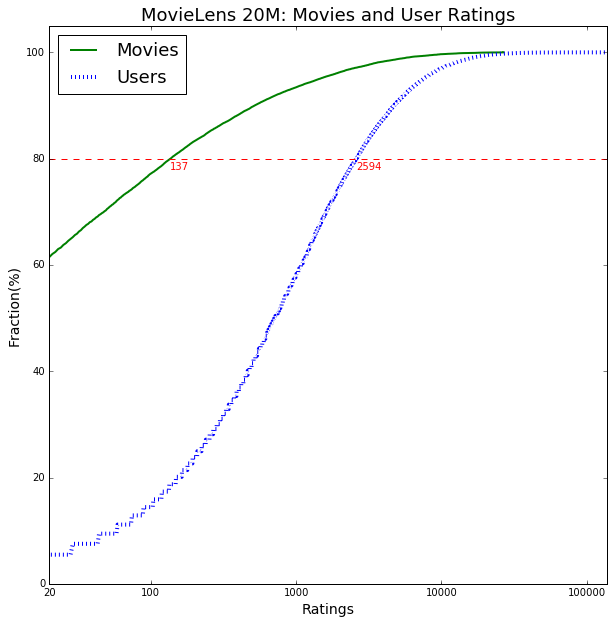

In [14]:
NUM_MOVIE_BINS = len(ratings_cnt["ratingsCount"])
NUM_USER_BINS = len(user_ratings_cnt["ratingsCount"])
movie_counts, bin_edges = np.histogram(ratings_cnt["ratingsCount"], bins=NUM_MOVIE_BINS)
movie_cdf = np.cumsum(movie_counts,dtype=float)

user_counts, bin_edges = np.histogram(user_ratings_cnt["ratingsCount"], bins=NUM_USER_BINS)
print user_counts
print bin_edges
user_cdf = np.cumsum(user_counts,dtype=float)


movie_cdf = movie_cdf/max(movie_cdf)*100.0
user_cdf = user_cdf/max(user_cdf)*100.0
#print user_cdf
fig,ax = plt.subplots()
fig.set_size_inches(10,10)
XMIN = 20.0
XMAX = max(NUM_MOVIE_BINS,NUM_USER_BINS)
plt.xlim(xmin=XMIN,xmax=XMAX)
plt.ylim(ymin=0.0,ymax=105)
print user_cdf[0]
for i in range(NUM_MOVIE_BINS):
    if movie_cdf[i] >= 80.0: # Finding the top 20 percentile
        print i
        break
for i in range(NUM_USER_BINS):
    if user_cdf[i] >= 80.0: # Finding the top 20 percentile
        print i
        break
        
        
        
ax.set_xscale('symlog', basex=10)

print movie_cdf.shape
plt.plot(movie_cdf,linewidth=2,linestyle="-",color="#008000")
plt.plot(user_cdf,linewidth=4,linestyle=":",color="#0000ff")
plt.plot([XMIN, XMAX], [80, 80], linewidth=1, linestyle="--",color="#ff0000")
ax.set_title("MovieLens 20M: Movie and User Ratings",fontsize=18)
ax.set_xlabel("Ratings",fontsize=14)
ax.set_ylabel("Fraction(%)",fontsize=14)
ax.legend(["Movies","Users"],loc="upper left",fontsize=18)
ax.text(137-2,78,"137",color="#ff0000")
ax.text(2594-2,78,"2594",color="#ff0000")
plt.xticks([20,100,1000,10000,100000],["20","100","1000","10000","100000"])
plt.savefig("movies_and_user_histogram.pdf",dpi=200)

In [ ]:
MOVIE_CUTOFF = 137
USER_CUTOFF = 2594
filetered_movie_ratings_cnt = 
